# Introduction
State notebook purpose here

### Imports
Import libraries and write settings here.

In [1]:

import seaborn as sb
import numpy as np
import pandas as pd
import pickle
from scipy.spatial import distance

from sklearn.metrics import roc_curve, auc, matthews_corrcoef, roc_auc_score, accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix
# Hyperparameter tuning

# Visualizations
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
# Set default font size
plt.rcParams['font.size'] = 24
# Set default font size
sb.set(font_scale=.8)
custom_style = {'axes.labelcolor': 'black',
                'xtick.color': 'black',
                'ytick.color': 'black'}
sb.set_style("white", rc=custom_style)

# Analysis/Modeling
Do work here

In [2]:
target_col =  "Cetuximab_Standard_3wks_cat"
datadir = "../../../dataset/5_McNemar_PDX_30x/"
tab_arr = []
split_index = 0
for split_index in range(30):
	# load the model from file
	suffix = str(split_index)
	f = "OmicsBinary_StackingCVClassifier_mutCross+clin+exprPROGENyHALLMARKS+highCNagg+MethK5cluster"
	modelFile = datadir + f + suffix + ".pkl"
	classifier = pickle.load(open(modelFile, 'rb'))
	# load test set
	f = "mutCross+clin+exprPROGENyHALLMARKS+highCNagg+MethK5cluster"
	XtestFile = datadir + f + suffix + "_Xtest.tsv"
	X_test = pd.read_csv(XtestFile, sep="\t", header=0, index_col=0)
	f = "OmicsBinary"
	YtestFile = datadir + f + suffix + "_Ytest.tsv"
	y_test = pd.read_csv(YtestFile, sep="\t", header=0,
				index_col=0)[target_col]
	y_test_predict_proba = classifier.predict_proba(X_test)
	fp_rates, tp_rates, _ = roc_curve(y_test,y_test_predict_proba[:,1])
	out_df = pd.DataFrame.from_dict({
		"replicate" : [suffix] * len(fp_rates),
		"fp_rate" : fp_rates,
		"tp_rate" : tp_rates
	})
	tab_arr.append(out_df)
rates_df = pd.concat(tab_arr)
rates_df["model"] = ['StackedCVClassifier'] * len(rates_df)
rates_df.shape
rates_df.head()

,replicate,fp_rate,tp_rate,model
0,0,0.000000,0.000000,StackedCVClassifier
1,0,0.000000,0.108108,StackedCVClassifier
2,0,0.000000,0.243243,StackedCVClassifier
3,0,0.030303,0.351351,StackedCVClassifier
4,0,0.030303,0.459459,StackedCVClassifier


In [3]:
f1 = '../../../dataset/5_McNemar_PDX_30x/OmicsBinary_StackingCVClassifier_mutCross+clin+exprPROGENyHALLMARKS+highCNagg+MethK5cluster_perfTab.tsv'
df1 = pd.read_csv(f1, sep='\t', header=0, index_col=0)
df1['test_set'] = ['full']*len(df1)
f2 = '../../../dataset/5_McNemar_PDX_30x/tripleNegONLY_OmicsBinary_StackingCVClassifier_mutCross+clin+exprPROGENyHALLMARKS+highCNagg+MethK5cluster_perfTab.tsv'
df2 = pd.read_csv(f2, sep='\t', header=0, index_col=0)
df2['test_set'] = ['tripleNegOnly']*len(df2)
f3 = '../../../dataset/5_McNemar_PDX_30x/CMPvPDX_OmicsBinary_StackingCVClassifier_mutCross+exprPROGENyHALLMARKS+highCNagg_perfTab.tsv' 
df3 = pd.read_csv(f3, sep='\t', header=0, index_col=0)
df3['test_set'] = ['mut+CNV+expr']*len(df3)



In [5]:
plot_data =pd.concat([df1, df3[df3.model_name == 'CMPstackedCVClassifier']])
plot_data["FPR"] = plot_data['true_PD__pred_SD-OR'] /\
	(plot_data['true_PD__pred_SD-OR'] + plot_data['true_SD-OR__pred_SD-OR']) 
medianFPR_tripleNeg = plot_data[
	plot_data.model_name == 'KRAS_BRAF_NRAS_triple_neg'].FPR.median()
medianFPR_tripleNeg 

0.24722222222222223

In [7]:

#  TP / (TP+FN)
plot_data["TPR"] = plot_data['true_SD-OR__pred_SD-OR'] /\
	(plot_data['true_SD-OR__pred_SD-OR'] + plot_data['true_SD-OR__pred_PD']) 
medianTPR_tripleNeg = plot_data[
	plot_data.model_name == 'KRAS_BRAF_NRAS_triple_neg'].TPR.median()
medianTPR_tripleNeg 

0.8918918918918919

# Results
Show graphs and stats here

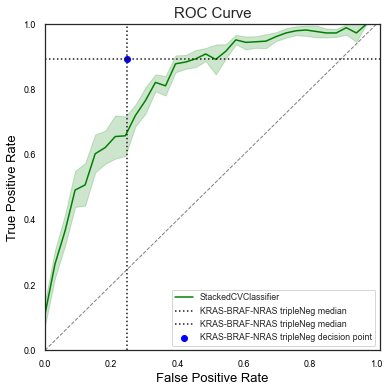

In [10]:
fig, ax = plt.subplots(figsize=(6,6))
sb.lineplot(data=rates_df, 
        x="fp_rate", 
        y="tp_rate",
        hue='model',
        palette=['green'],
        lw=1.5,
        ax=ax)

ax.plot([0, 1], [
        0, 1], 
        lw=1, 
        linestyle='--', 
        color='grey')
ax.axvline(medianFPR_tripleNeg, ls=':', c='k', 
        label='KRAS-BRAF-NRAS tripleNeg median')
ax.scatter(medianFPR_tripleNeg, medianTPR_tripleNeg, 
        c='blue', label='KRAS-BRAF-NRAS tripleNeg decision point')
ax.axhline(medianTPR_tripleNeg, ls=':', c='k', 
        label='KRAS-BRAF-NRAS tripleNeg median')
ax.legend()
ax.set_xlim([0.0, 1.01])
ax.set_ylim([0.0, 1])
ax.set_xlabel('False Positive Rate', size=13)
ax.set_ylabel('True Positive Rate', size=13)
ax.set_title('ROC Curve', size=15)
fig.savefig(f"internalValidation_aggregateROCAUC_StackedVtripleNeg_ROCcurve.pdf", format='pdf', 
            bbox_inches='tight', dpi=fig.dpi)
fig.savefig(f"internalValidation_aggregateROCAUC_StackedVtripleNeg_ROCcurve.png", format='png', 
            bbox_inches='tight', dpi=fig.dpi)

# Conclusions and Next Steps
Summarize findings here